In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [6]:
# Load the datasets
train_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/train2.csv')
test_data = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/test2.csv')


In [7]:
# Make copies for LEAR model
train_data_lear = train_data.copy()
test_data_lear = test_data.copy()

# Make copies for DNN model
train_data_dnn = train_data.copy()
test_data_dnn = test_data.copy()

In [8]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert 'Datetime' to datetime object and sort data
train_data_lear['local_time'] = pd.to_datetime(train_data_lear['local_time'])
train_data_lear.sort_values('local_time', inplace=True)
test_data_lear['local_time'] = pd.to_datetime(test_data_lear['local_time'])
test_data_lear.sort_values('local_time', inplace=True)

# Extract datetime features
train_data_lear['hour'] = train_data_lear['local_time'].dt.hour
train_data_lear['day_of_week'] = train_data_lear['local_time'].dt.dayofweek
train_data_lear['month'] = train_data_lear['local_time'].dt.month
test_data_lear['hour'] = test_data_lear['local_time'].dt.hour
test_data_lear['day_of_week'] = test_data_lear['local_time'].dt.dayofweek
test_data_lear['month'] = test_data_lear['local_time'].dt.month

# Function to create lagged features
def create_lagged_features(df, target, lag_days):
    for lag in lag_days:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df.dropna()

# Create lagged features
lag_days = [1, 2, 7]
train_data_lear = create_lagged_features(train_data_lear, 'MW', lag_days)
test_data_lear = create_lagged_features(test_data_lear, 'MW', lag_days)

# Prepare training and testing data
X_train_lear = train_data_lear.drop(['MW', 'local_time'], axis=1)  
y_train_lear = train_data_lear['MW']
X_test_lear = test_data_lear.drop(['MW', 'local_time'], axis=1)  
y_test_lear = test_data_lear['MW']

# Initialize and train the Lasso model
lear_model = Lasso(alpha=0.1)
lear_model.fit(X_train_lear, y_train_lear)

# Make predictions with LEAR model
lear_predictions = lear_model.predict(X_test_lear)

# Function to calculate metrics
def calculate_metrics(actual, predicted, threshold=1):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is less than or equal to the threshold
    valid_actual = actual[actual > threshold]
    corresponding_predicted = predicted[actual > threshold]

    # Calculate MAPE for valid actual values
    mape = np.mean(np.abs((valid_actual - corresponding_predicted) / valid_actual)) * 100

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    # Get the pairs that were excluded
    excluded_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act <= threshold]

    return mae, mape, smape, rmse, excluded_pairs

# Calculate metrics
mae, mape, smape, rmse, excluded_pairs = calculate_metrics(y_test_lear, lear_predictions)

# Print the metrics
print("LEAR Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

# Print the excluded pairs
print("Excluded pairs (Actual, Predicted):", excluded_pairs)



LEAR Metrics:
MAE: 6.533818493294748
MAPE: 15.54371620976551
sMAPE: 15.809652629578707
RMSE: 13.22650909755035
Excluded pairs (Actual, Predicted): [(-0.03183, 6.528915174475072), (-1.68827, 7.099259419750483), (-3.04641, 7.305834500892736), (-3.36158, 5.571214136707239), (-1.89195, 2.275547492675381), (0.01, 2.4418564872100603), (0.70807, -3.1017771501504097), (-2.44903, 6.722175722621493), (-3.81538, 3.683760421837798), (-4.75788, 4.52196067160058), (-5.04993, 2.9752873027435287), (-3.34572, -0.21895015192074707), (-0.0111, 0.7096211421863363), (-1.0466, 13.729273042417066), (-0.07002, 9.330802336097022), (0.7136, 7.054812582553703), (-0.07693, 12.375283526379317), (-1.33392, 4.212380689041218), (-2.68071, 6.718658843663965), (-2.73914, 5.6734365322811104), (-4.95548, 4.457780497310302), (-1.15735, -0.4193420555762568), (0.98677, 5.350967766631777), (0.8696, 4.105703360675069), (0.9038, 3.024908669775421), (-0.50221, 7.880739686930593), (-1.0532, 6.599896888482174), (-1.18986, 6.61378

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Make copies for DNN model
train_data_dnn = train_data.copy()
test_data_dnn = test_data.copy()

# Scale the DNN data
scaler = StandardScaler()
X_train_dnn = scaler.fit_transform(train_data_dnn.drop(['MW', 'local_time'], axis=1))
y_train_dnn = train_data_dnn['MW'].values
X_test_dnn = scaler.transform(test_data_dnn.drop(['MW', 'local_time'], axis=1))
y_test_dnn = test_data_dnn['MW'].values

# Define the DNN model architecture
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the DNN model
dnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the DNN model
dnn_history = dnn_model.fit(X_train_dnn, y_train_dnn, epochs=100, batch_size=32)

# Make predictions
dnn_predictions = dnn_model.predict(X_test_dnn).flatten()

# def calculate_metrics(actual, predicted):
#     mae = mean_absolute_error(actual, predicted)
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     rmse = np.sqrt(mean_squared_error(actual, predicted))
#     smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
#     return mae, mape, smape, rmse

# # Calculate metrics for DNN
# dnn_metrics = calculate_metrics(y_test_dnn, dnn_predictions)
# print("DNN Metrics:", dnn_metrics)

def calculate_metrics(actual, predicted, threshold=1, mape_threshold=300):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Filter out pairs where the actual value is less than or equal to the threshold
    valid_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act > threshold]
    valid_actual, corresponding_predicted = zip(*valid_pairs)

    # Convert to numpy arrays for further calculations
    valid_actual = np.array(valid_actual)
    corresponding_predicted = np.array(corresponding_predicted)

    # Calculate MAPE for valid actual values
    mape_errors = np.abs((valid_actual - corresponding_predicted) / valid_actual) * 100
    filtered_mape_errors = mape_errors[mape_errors < mape_threshold]
    mape = np.mean(filtered_mape_errors)

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    # Get the pairs that were excluded
    excluded_pairs = [(act, pred) for act, pred in zip(actual, predicted) if act <= threshold or abs((act - pred) / act) * 100 >= mape_threshold]

    return mae, mape, smape, rmse, excluded_pairs

# Calculate metrics for DNN model
mae, mape, smape, rmse, excluded_pairs = calculate_metrics(y_test_dnn, dnn_predictions, threshold=1, mape_threshold=300)


# Print the excluded pairs
print("Excluded pairs (Actual, Predicted):", excluded_pairs)
# Print the metrics
print("DNN Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

Epoch 1/100
548/548 [==============================] - 2s 2ms/step - loss: 4398.6343
Epoch 2/100
548/548 [==============================] - 1s 2ms/step - loss: 3765.7070
Epoch 3/100
548/548 [==============================] - 1s 2ms/step - loss: 3756.7151
Epoch 4/100
548/548 [==============================] - 1s 2ms/step - loss: 3758.7114
Epoch 5/100
548/548 [==============================] - 1s 2ms/step - loss: 3757.0461
Epoch 6/100
548/548 [==============================] - 1s 2ms/step - loss: 3758.2207
Epoch 7/100
548/548 [==============================] - 1s 2ms/step - loss: 3748.7136
Epoch 8/100
548/548 [==============================] - 1s 2ms/step - loss: 3745.8655
Epoch 9/100
548/548 [==============================] - 1s 2ms/step - loss: 3744.5588
Epoch 10/100
548/548 [==============================] - 1s 2ms/step - loss: 3738.9595
Epoch 11/100
548/548 [==============================] - 1s 2ms/step - loss: 3733.9250
Epoch 12/100
548/548 [==============================] - 1s 2ms/

In [10]:
# Print the metrics
print("DNN Metrics:")
print("MAE:", mae)
print("MAPE:", mape)
print("sMAPE:", smape)
print("RMSE:", rmse)

DNN Metrics:
MAE: 28.885353277016904
MAPE: 49.76893507981634
sMAPE: 47.77151455048092
RMSE: 42.27833848692582


In [11]:
import pandas as pd

# DNN Comparison DataFrame
comparison_df1 = pd.DataFrame({
    'Actual': y_test_dnn,  
    'DNN Predictions': dnn_predictions
})

# Aligning LEAR predictions with actual values
num_predictions_lear = len(lear_predictions)
y_test_lear_aligned = y_test_lear[-num_predictions_lear:]

# LEAR Comparison DataFrame
comparison_df2 = pd.DataFrame({
    'Actual': y_test_lear_aligned,
    'LEAR Predictions': lear_predictions
})

# Print the Comparison DataFrames
print("DNN Model Predictions vs Actual:")
print(comparison_df1)
print("\nLEAR Model Predictions vs Actual:")
print(comparison_df2)


DNN Model Predictions vs Actual:
         Actual  DNN Predictions
0     117.83241        74.059639
1     119.51455        73.651711
2     114.00266        76.450325
3     112.82553        79.154739
4     108.65000        79.790558
...         ...              ...
8756   50.05301        74.448608
8757   50.08335        76.260597
8758   49.23503        77.342171
8759   46.34927        77.797691
8760   45.81851        79.610252

[8761 rows x 2 columns]

LEAR Model Predictions vs Actual:
         Actual  LEAR Predictions
7     126.76553        105.624880
8     124.93580        125.294156
9     104.92544        115.370059
10     83.15000         90.134501
11     69.72865         70.658986
...         ...               ...
8756   50.05301         52.312823
8757   50.08335         52.877385
8758   49.23503         53.189571
8759   46.34927         52.520348
8760   45.81851         49.752286

[8754 rows x 2 columns]


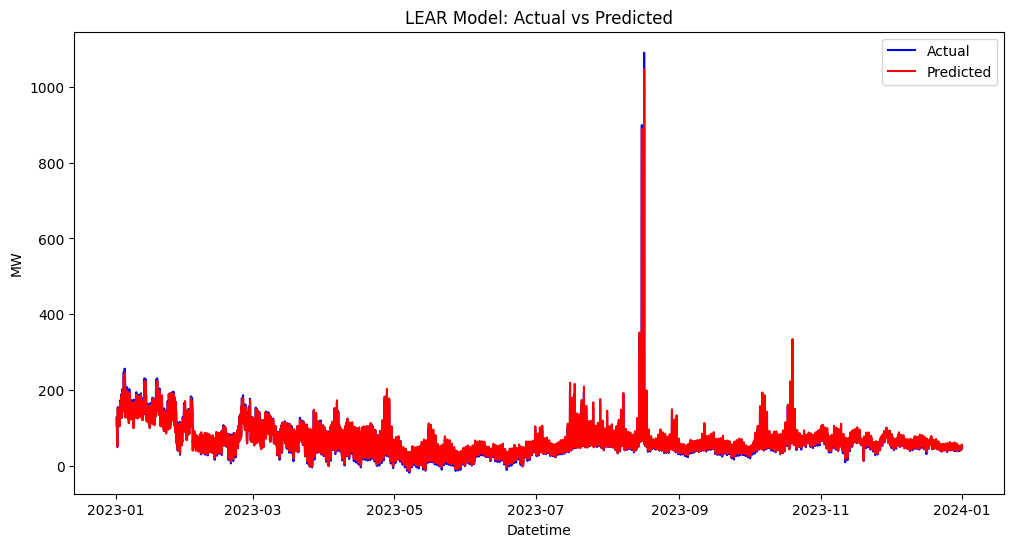

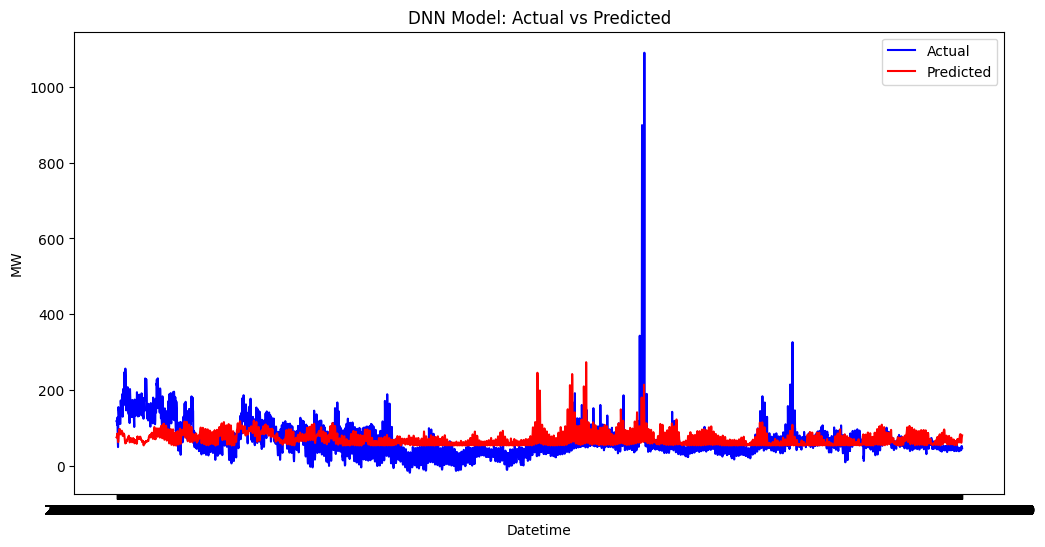

In [13]:
import matplotlib.pyplot as plt


# For LEAR Model
datetime_lear_aligned = test_data_lear['local_time'][-len(lear_predictions):]

# For DNN Model
datetime_dnn_aligned = test_data['local_time'][-len(dnn_predictions):] 

# Plotting for LEAR model
plt.figure(figsize=(12, 6))
plt.plot(datetime_lear_aligned, y_test_lear[-len(lear_predictions):], label='Actual', color='blue')
plt.plot(datetime_lear_aligned, lear_predictions, label='Predicted', color='red')
plt.title('LEAR Model: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()

# Plotting for DNN model
plt.figure(figsize=(12, 6))
plt.plot(datetime_dnn_aligned, y_test_dnn[-len(dnn_predictions):], label='Actual', color='blue')
plt.plot(datetime_dnn_aligned, dnn_predictions, label='Predicted', color='red')
plt.title('DNN Model: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()


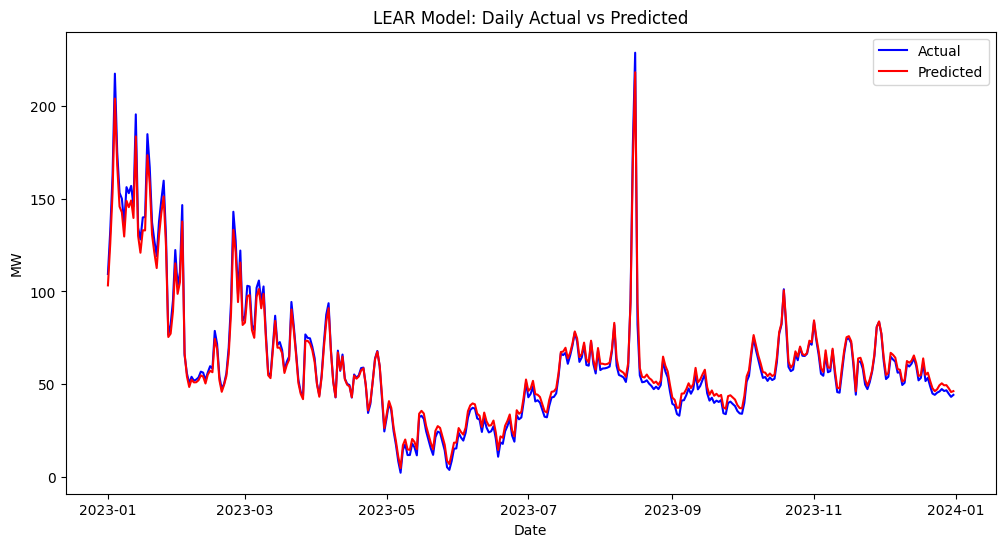

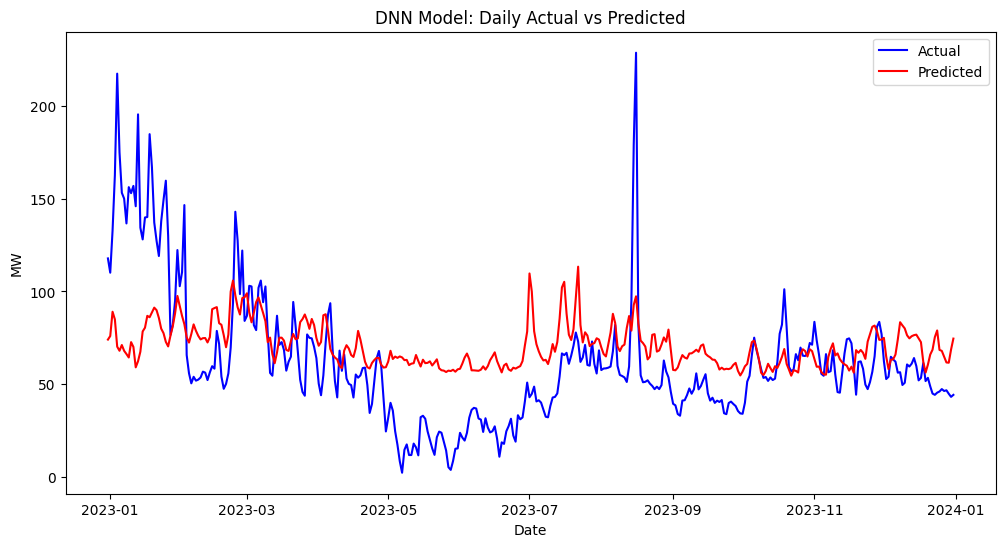

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure that 'Datetime' columns are in datetime format
test_data_lear['local_time'] = pd.to_datetime(test_data_lear['local_time'])
test_data['local_time'] = pd.to_datetime(test_data['local_time'])

# Aligning the datetime data for LEAR and DNN models
datetime_lear_aligned = test_data_lear['local_time'][-len(lear_predictions):]
datetime_dnn_aligned = test_data['local_time'][-len(dnn_predictions):]

# Convert datetime to date (to group by day)
datetime_lear_aligned = datetime_lear_aligned.dt.date
datetime_dnn_aligned = datetime_dnn_aligned.dt.date

# For LEAR model
lear_grouped = pd.DataFrame({'local_time': datetime_lear_aligned, 'Actual': y_test_lear[-len(lear_predictions):], 'Predicted': lear_predictions})
lear_daily = lear_grouped.groupby('local_time').mean()

# For DNN model
dnn_grouped = pd.DataFrame({'local_time': datetime_dnn_aligned, 'Actual': y_test_dnn[-len(dnn_predictions):], 'Predicted': dnn_predictions})
dnn_daily = dnn_grouped.groupby('local_time').mean()

# Plotting
# LEAR Model
plt.figure(figsize=(12, 6))
plt.plot(lear_daily.index, lear_daily['Actual'], label='Actual', color='blue')
plt.plot(lear_daily.index, lear_daily['Predicted'], label='Predicted', color='red')
plt.title('LEAR Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()
plt.close()

# DNN Model
plt.figure(figsize=(12, 6))
plt.plot(dnn_daily.index, dnn_daily['Actual'], label='Actual', color='blue')
plt.plot(dnn_daily.index, dnn_daily['Predicted'], label='Predicted', color='red')
plt.title('DNN Model: Daily Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.show()
plt.close()
